# Stochastic Processes Project

Jean Duboscq, Keshav Ganesh, Daniyar Zakarin

## Project 10:

Description:  Escape of a particle from an intracellular region: A particle is diffusing according to Brownian motion in a 2D circular domain of radius $r$. The particle can only exit the domain from an opening defined by a segment of a circle of angular width $\theta$.

We investigate the mean exit time of the domain as a function of the angular width $\theta$.

## General Imports

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import sys
import datetime

### Basic Implementation

Here, we fix the radius of the circle to be 1 and the diffusion coefficient to be 1. We will use the following parameters for the simulation:

- $r = 1$
- $D = 1$
- $x_0 = (0, 0)$

In the following code, we set $\theta$ to be $\pi$/4, just to see general behavior of the particles.

In [13]:
# Parameters
r = 1.0  # radius of the circle
theta = np.pi / 4  # exit angular width
D = 1.0  # diffusion constant
dt = 0.01  # time step
num_particles = 10000  # number of particles to simulate

In [14]:
def is_in_exit_segment(x, y, theta):
    angle = np.arctan2(y, x)
    return -theta/2 <= angle <= theta/2

Here we write a function to reflect the particle off the boundary of the circle. This only occurs if at any point the particle is outside the circle in the angular region which is not the opening.

In [15]:
def reflect(x, y, x_prev, y_prev, r):
    # Calculate the coefficients of the quadratic equation
    dx = x - x_prev
    dy = y - y_prev
    a = dx**2 + dy**2
    b = 2 * (x_prev * dx + y_prev * dy)
    c = x_prev**2 + y_prev**2 - r**2
    
    discriminant = b**2 - 4 * a * c
    
    if discriminant < 0:
        raise ValueError("Discriminant is negative. Check the input values.")
    
    sqrt_discriminant = np.sqrt(discriminant)
    
    t1 = (-b + sqrt_discriminant) / (2 * a)
    t2 = (-b - sqrt_discriminant) / (2 * a)
    
    # Select the correct intersection point
    t = None
    if 0 <= t1 <= 1:
        t = t1
    elif 0 <= t2 <= 1:
        t = t2
    if t is None:
        raise ValueError("Both intersection points are out of bounds.")
    
    x_intersection = x_prev + t * dx
    y_intersection = y_prev + t * dy
    
    # Calculate the normal vector at the intersection point
    normal_x = x_intersection / r
    normal_y = y_intersection / r
    
    # Calculate the incident vector
    incident_x = x - x_intersection
    incident_y = y - y_intersection
    
    # Reflect the incident vector across the normal vector
    dot_product = incident_x * normal_x + incident_y * normal_y
    reflection_x = incident_x - 2 * dot_product * normal_x
    reflection_y = incident_y - 2 * dot_product * normal_y
    
    # Calculate the reflected position
    x_reflection = x_intersection + reflection_x
    y_reflection = y_intersection + reflection_y
    
    return x_reflection, y_reflection


In [7]:
def simulate_particle():
    # Start at the center
    x, y = 0.0, 0.0
    x_prev, y_prev = x, y
    time = 0.0
    
    while True:
        # Brownian motion: update position with random steps
        step_size = np.sqrt(2 * D * dt)
        dx = step_size * np.random.randn()
        dy = step_size * np.random.randn()
        x_new = x + dx
        y_new = y + dy
        
        # Check if particle is outside the circle
        if x_new**2 + y_new**2 > r**2:
            if is_in_exit_segment(x_new, y_new, theta):
                return time
            else:
                # Reflect the particle back
                try:
                    x, y = reflect(x_new, y_new, x, y, r)
                except ValueError:
                    # Handle the case where reflection calculation fails
                    x, y = x_prev, y_prev  # Reset to previous position
        else:
            x, y = x_new, y_new
        
        # Increment the time by delta_t
        time += dt
        x_prev, y_prev = x, y

In [82]:
mean_exit_times = [simulate_particle() for _ in range(num_particles)]
mean_exit_time = np.mean(mean_exit_times)
print(f"Mean exit time (discretized with Brownian motion and elastic reflection): {mean_exit_time}")

Mean exit time (discretized with Brownian motion and elastic reflection): 2.3330939999999805


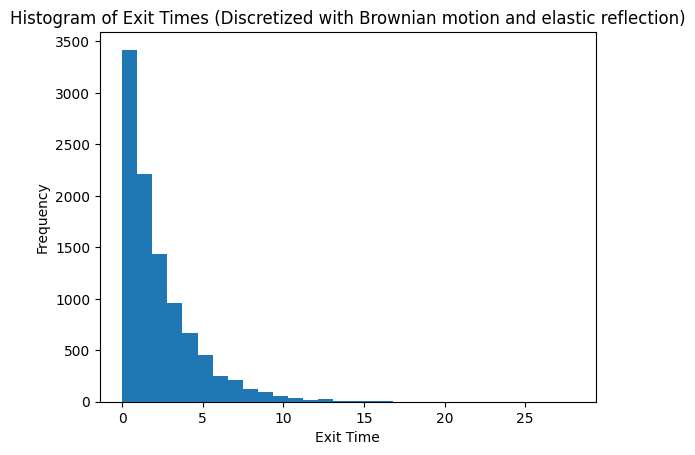

In [56]:
# Plot histogram of exit times
plt.hist(mean_exit_times, bins=30)
plt.xlabel('Exit Time')
plt.ylabel('Frequency')
plt.title('Histogram of Exit Times (Discretized with Brownian motion and elastic reflection)')
plt.show()

Now, we alter the parameter $\theta$ to see how the mean exit time changes.

In [19]:
# create function to run simulation with different theta values

def simulate_particle_theta(theta, x_start=0.0, y_start=0.0):
    # Start at the center
    x, y = x_start, y_start
    x_prev, y_prev = x, y
    time = 0.0
    
    while True:
        # Brownian motion: update position with random steps
        step_size = np.sqrt(2 * D * dt)
        dx = step_size * np.random.randn()
        dy = step_size * np.random.randn()
        x_new = x + dx
        y_new = y + dy
        
        # Check if particle is outside the circle
        if x_new**2 + y_new**2 > r**2:
            if is_in_exit_segment(x_new, y_new, theta):
                return time
            else:
                # Reflect the particle back
                try:
                    x, y = reflect(x_new, y_new, x, y, r)
                except ValueError:
                    # Handle the case where reflection calculation fails
                    x, y = x_prev, y_prev  # Reset to previous position
        else:
            x, y = x_new, y_new
        
        # Increment the time by delta_t
        time += dt
        x_prev, y_prev = x, y

In [21]:
def mean_exit_time_theta(theta, num_particles, x_start=0.0, y_start=0.0):
    mean_exit_times = [simulate_particle_theta(theta, x_start, y_start) for _ in range(num_particles)]
    mean_exit_time = np.mean(mean_exit_times)
    return mean_exit_time

Time taken to run simulation with different theta values: 121.13823008537292 seconds
[5.065838999999963, 3.3709139999999667, 2.6690359999999758, 2.2711049999999813, 1.936703999999986, 1.7305129999999889, 1.513985999999992, 1.3758769999999936, 1.2291859999999952, 1.1155909999999964, 1.021166999999997, 0.924955999999998, 0.8388379999999986, 0.7609269999999991, 0.6986859999999995, 0.6441699999999996, 0.6028839999999999, 0.558954, 0.5078790000000001, 0.46801000000000015, 0.4331960000000002, 0.40516800000000014, 0.37692800000000015, 0.3574680000000001, 0.33578300000000016, 0.3205080000000002, 0.3089840000000001, 0.2961930000000001, 0.2954140000000001, 0.28607700000000014]
[0.19634954 0.40624043 0.61613132 0.82602221 1.03591309 1.24580398
 1.45569487 1.66558576 1.87547665 2.08536754 2.29525843 2.50514931
 2.7150402  2.92493109 3.13482198 3.34471287 3.55460376 3.76449465
 3.97438553 4.18427642 4.39416731 4.6040582  4.81394909 5.02383998
 5.23373086 5.44362175 5.65351264 5.86340353 6.07329442 

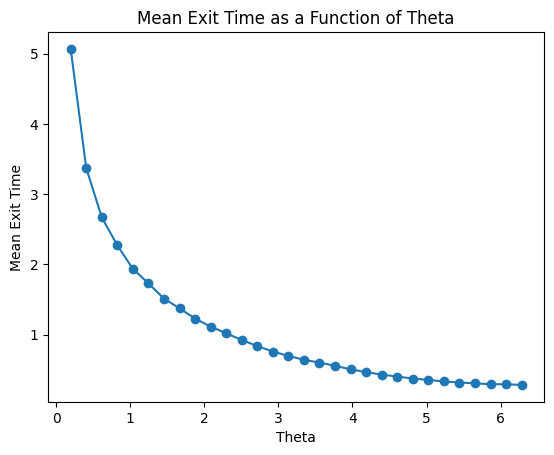

In [18]:
# run simulation with different theta values

theta_values = np.linspace(np.pi/16, 2*np.pi, 30)

start_time = time.time()

mean_exit_times_theta_list = [mean_exit_time_theta(theta, 10000) for theta in theta_values]

end_time = time.time()

print(f"Time taken to run simulation with different theta values: {end_time - start_time} seconds")

# Plot mean exit time as a function of theta

print(mean_exit_times_theta_list)
print(theta_values)

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.show()

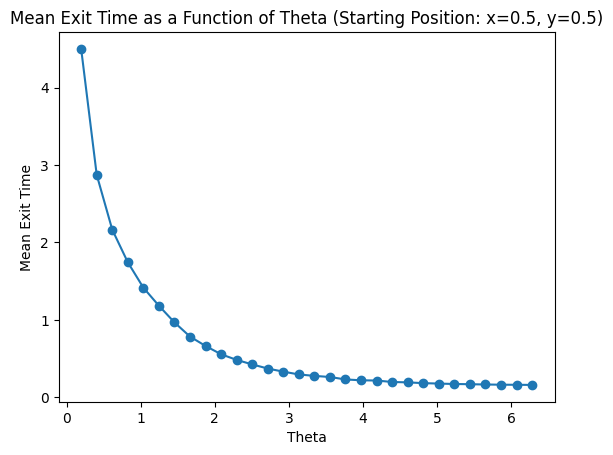

In [22]:
# change starting position of particles

mean_exit_times_theta_list = [mean_exit_time_theta(theta, 10000, 0.5, 0.5) for theta in theta_values]

plt.plot(theta_values, mean_exit_times_theta_list, marker='o')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta (Starting Position: x=0.5, y=0.5)')
plt.show()

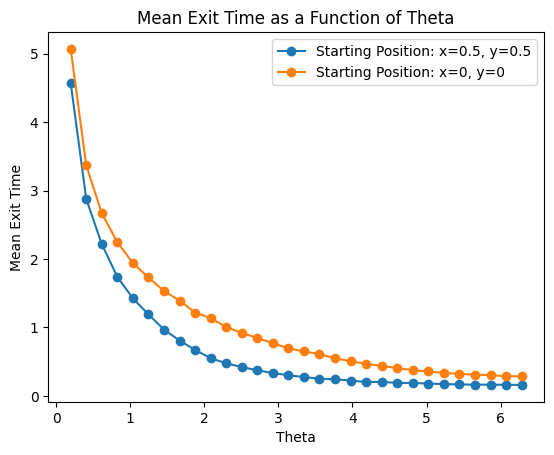

In [23]:
# plot both curves

mean_exit_times_theta_list_moved = [mean_exit_time_theta(theta, 10000, 0.5, 0.5) for theta in theta_values]
mean_exit_times_theta_list = [mean_exit_time_theta(theta, 10000) for theta in theta_values]

plt.plot(theta_values, mean_exit_times_theta_list_moved, marker='o', label='Starting Position: x=0.5, y=0.5')
plt.plot(theta_values, mean_exit_times_theta_list, marker='o', label='Starting Position: x=0, y=0')
plt.xlabel('Theta')
plt.ylabel('Mean Exit Time')
plt.title('Mean Exit Time as a Function of Theta')
plt.legend()
plt.show()